# Advanced Machine Learning Project
This notebook analyzes the pistachio dataset using advanced machine learning techniques for anomaly detection and classification.

## Objectives:
- Perform data cleaning and preprocessing
- Apply dimensionality reduction (PCA, LDA)
- Implement anomaly detection
- Train and evaluate classification models
- Visualize results

---


#Libraries

In [18]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


In [9]:
#unzip output folder
!unzip -j output.zip

Archive:  output.zip
  inflating: corrected_data.csv      
  inflating: lda_reduced_data.csv    
  inflating: normalized_data.csv     
  inflating: pca_reduced_data.csv    
  inflating: standardized_data.csv   


In [6]:
# Paths to the output CSV files
output_files = [
    "corrected_data.csv",
    "standardized_data.csv",
    "normalized_data.csv",
    "pca_reduced_data.csv",
    "lda_reduced_data.csv"
    ]

In [5]:
for file in output_files:
  data = pd.read_csv(file)
  print(file)
  print("Number of instances:", data.shape[0])
  print("Features:", data.columns)
  print("\n")

corrected_data.csv
Number of instances: 2148
Features: Index(['Area', 'Perimeter', 'Major_Axis', 'Minor_Axis', 'Eccentricity',
       'Eqdiasq', 'Solidity', 'Convex_Area', 'Extent', 'Aspect_Ratio',
       'Roundness', 'Compactness', 'Shapefactor_1', 'Shapefactor_2',
       'Shapefactor_3', 'Shapefactor_4', 'Mean_RR', 'Mean_RG', 'Mean_RB',
       'StdDev_RR', 'StdDev_RG', 'StdDev_RB', 'Skew_RR', 'Skew_RG', 'Skew_RB',
       'Kurtosis_RR', 'Kurtosis_RG', 'Kurtosis_RB', 'Class'],
      dtype='object')


standardized_data.csv
Number of instances: 2148
Features: Index(['Area', 'Perimeter', 'Major_Axis', 'Minor_Axis', 'Eccentricity',
       'Eqdiasq', 'Solidity', 'Convex_Area', 'Extent', 'Aspect_Ratio',
       'Roundness', 'Compactness', 'Shapefactor_1', 'Shapefactor_2',
       'Shapefactor_3', 'Shapefactor_4', 'Mean_RR', 'Mean_RG', 'Mean_RB',
       'StdDev_RR', 'StdDev_RG', 'StdDev_RB', 'Skew_RR', 'Skew_RG', 'Skew_RB',
       'Kurtosis_RR', 'Kurtosis_RG', 'Kurtosis_RB', 'Class'],
      dty

In [6]:
for file_path in output_files:
    # Load the dataset
    df = pd.read_csv(file_path)
    print(df.columns)

Index(['Area', 'Perimeter', 'Major_Axis', 'Minor_Axis', 'Eccentricity',
       'Eqdiasq', 'Solidity', 'Convex_Area', 'Extent', 'Aspect_Ratio',
       'Roundness', 'Compactness', 'Shapefactor_1', 'Shapefactor_2',
       'Shapefactor_3', 'Shapefactor_4', 'Mean_RR', 'Mean_RG', 'Mean_RB',
       'StdDev_RR', 'StdDev_RG', 'StdDev_RB', 'Skew_RR', 'Skew_RG', 'Skew_RB',
       'Kurtosis_RR', 'Kurtosis_RG', 'Kurtosis_RB', 'Class'],
      dtype='object')
Index(['Area', 'Perimeter', 'Major_Axis', 'Minor_Axis', 'Eccentricity',
       'Eqdiasq', 'Solidity', 'Convex_Area', 'Extent', 'Aspect_Ratio',
       'Roundness', 'Compactness', 'Shapefactor_1', 'Shapefactor_2',
       'Shapefactor_3', 'Shapefactor_4', 'Mean_RR', 'Mean_RG', 'Mean_RB',
       'StdDev_RR', 'StdDev_RG', 'StdDev_RB', 'Skew_RR', 'Skew_RG', 'Skew_RB',
       'Kurtosis_RR', 'Kurtosis_RG', 'Kurtosis_RB', 'Class'],
      dtype='object')
Index(['Area', 'Perimeter', 'Major_Axis', 'Minor_Axis', 'Eccentricity',
       'Eqdiasq', 'Solidity', 

#Outlier Detection

In [22]:
def anomaly_detection(data_files, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for file_path in data_files:
        print(f"Processing dataset: {file_path}")

        # Load the dataset
        df = pd.read_csv(file_path)

        # Drop class labels for unsupervised outlier detection
        X = df.drop(columns=['Class'])

        # Initialize the outlier detection models
        clf_lof = LocalOutlierFactor(n_neighbors=20, metric='euclidean', contamination='auto')
        clf_isf = IsolationForest(contamination='auto', random_state=42)
        clf_ocsvm = OneClassSVM(nu=0.1, gamma='scale')

        # Detect outliers using each model
        y_pred_lof = clf_lof.fit_predict(X)
        y_pred_isf = clf_isf.fit_predict(X)
        y_pred_ocsvm = clf_ocsvm.fit_predict(X)

        # Convert predictions to boolean arrays for easy counting
        is_outlier_lof = y_pred_lof == -1
        is_outlier_isf = y_pred_isf == -1
        is_outlier_ocsvm = y_pred_ocsvm == -1

        # Count outliers detected by each method
        n_outliers_lof = np.sum(is_outlier_lof)
        n_outliers_isf = np.sum(is_outlier_isf)
        n_outliers_ocsvm = np.sum(is_outlier_ocsvm)

        # Identify common outliers detected by all methods
        outliers_common = np.logical_and(np.logical_and(is_outlier_lof, is_outlier_isf), is_outlier_ocsvm)
        n_common_outliers = np.sum(outliers_common)

        # Print the count of outliers detected by each method
        print(f"Number of LOF outliers: {n_outliers_lof}")
        print(f"Number of ISF outliers: {n_outliers_isf}")
        print(f"Number of OCSVM outliers: {n_outliers_ocsvm}")
        print(f"Number of common outliers (LOF, ISF, OCSVM): {n_common_outliers}")

        # Add outlier flags to the DataFrame
        df['LOF_Outlier'] = is_outlier_lof
        df['ISF_Outlier'] = is_outlier_isf
        df['OCSVM_Outlier'] = is_outlier_ocsvm
        df['Common_Outliers'] = outliers_common  # True for common outliers

        # Save the DataFrame with anomaly scores
        output_file_path = os.path.join(output_folder, os.path.basename(file_path))
        df.to_csv(output_file_path, index=True)

# Specify your output files and the output folder
output_files = [
    "corrected_data.csv",
    "standardized_data.csv",
    "normalized_data.csv",
    "pca_reduced_data.csv",
    "lda_reduced_data.csv"
]

output_folder_anomaly_scores = "output_anomaly_scores"

# Execute the function
anomaly_detection(output_files, output_folder_anomaly_scores)


Processing dataset: corrected_data.csv
Number of LOF outliers: 44
Number of ISF outliers: 169
Number of OCSVM outliers: 216
Number of common outliers (LOF, ISF, OCSVM): 11
Processing dataset: standardized_data.csv
Number of LOF outliers: 27
Number of ISF outliers: 169
Number of OCSVM outliers: 218
Number of common outliers (LOF, ISF, OCSVM): 21
Processing dataset: normalized_data.csv
Number of LOF outliers: 19
Number of ISF outliers: 169
Number of OCSVM outliers: 217
Number of common outliers (LOF, ISF, OCSVM): 16
Processing dataset: pca_reduced_data.csv
Number of LOF outliers: 28
Number of ISF outliers: 102
Number of OCSVM outliers: 215
Number of common outliers (LOF, ISF, OCSVM): 22
Processing dataset: lda_reduced_data.csv
Number of LOF outliers: 0
Number of ISF outliers: 2148
Number of OCSVM outliers: 2148
Number of common outliers (LOF, ISF, OCSVM): 0


In [11]:
!zip -r output_anomaly_scores.zip output_anomaly_scores

updating: output_anomaly_scores/ (stored 0%)
updating: output_anomaly_scores/lda_reduced_data.csv (deflated 96%)
updating: output_anomaly_scores/pca_reduced_data.csv (deflated 58%)
updating: output_anomaly_scores/corrected_data.csv (deflated 63%)
updating: output_anomaly_scores/normalized_data.csv (deflated 60%)
updating: output_anomaly_scores/standardized_data.csv (deflated 58%)


#Classification

In [23]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

def classification(data_files):
    overall_results = []
    plots_folder = "classification_plots"
    os.makedirs(plots_folder, exist_ok=True)

    for file_path in data_files:
        print(f"Processing dataset: {file_path}")
        results = []
        df = pd.read_csv(file_path)

        X = df.drop(columns=['Class'])
        y = df['Class']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        classifiers = {
            "Random Forest": {
                "model": RandomForestClassifier(criterion='entropy'),
                "params": {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}
            },
            "Naive Bayes": {
                "model": GaussianNB(),
                "params": {'var_smoothing': np.logspace(-10, -7, 4)}
            },
            "MLP": {
                "model": MLPClassifier(max_iter=1000),
                "params": {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'alpha': [0.0001, 0.001, 0.01], 'learning_rate_init': [0.001, 0.01], 'momentum': [0.5, 0.7, 0.9]}
            }
        }

        for classifier_name, classifier in classifiers.items():
            random_search = RandomizedSearchCV(classifier["model"], classifier["params"], n_iter=10, cv=3, n_jobs=-1, scoring='f1_macro', random_state=42)
            random_search.fit(X_train, y_train)
            best_clf = random_search.best_estimator_
            predictions = best_clf.predict(X_test)

            accuracy = accuracy_score(y_test, predictions)
            f1 = f1_score(y_test, predictions, average='macro')
            precision = precision_score(y_test, predictions, average='macro')
            recall = recall_score(y_test, predictions, average='macro')

            print(f"{classifier_name} Best Parameters: {random_search.best_params_}")
            print(f"{classifier_name} Classification Report:")
            print(classification_report(y_test, predictions))
            print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

            results.append({"Dataset": os.path.basename(file_path), "Classifier": classifier_name, "Accuracy": accuracy, "F1 Score": f1, "Precision": precision, "Recall": recall, "Best Parameters": str(random_search.best_params_)})

            print("="*50)

        overall_results.extend(results)

    results_df = pd.DataFrame(overall_results)
    print(results_df)

    for metric in ["Accuracy", "F1 Score", "Precision", "Recall"]:
        plt.figure(figsize=(10, 7))
        sns.barplot(x=metric, y='Dataset', hue='Classifier', data=results_df, palette='coolwarm')
        plt.title(f'Classifier {metric} Comparison Across Datasets')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_folder, f'classifier_{metric.lower()}_comparison.jpeg'))
        plt.close()

    shutil.make_archive(plots_folder, 'zip', plots_folder)

    return f"{plots_folder}.zip"

# Example usage
output_files = [
    "corrected_data.csv",
    "standardized_data.csv",
    "normalized_data.csv",
    "pca_reduced_data.csv",
]

# Call the classification function with the list of dataset paths
zip_file_path = classification(output_files)

# Print the path to the zipped folder containing all plots
print(f"All plots and confusion matrices have been saved and zipped here: {zip_file_path}")

Processing dataset: corrected_data.csv
Random Forest Best Parameters: {'n_estimators': 50, 'min_samples_split': 5, 'max_depth': 10}
Random Forest Classification Report:
                   precision    recall  f1-score   support

Kirmizi_Pistachio       0.93      0.92      0.93       244
  Siirt_Pistachio       0.90      0.91      0.91       186

         accuracy                           0.92       430
        macro avg       0.92      0.92      0.92       430
     weighted avg       0.92      0.92      0.92       430

Accuracy: 0.9186, F1 Score: 0.9173, Precision: 0.9165, Recall: 0.9181


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Naive Bayes Best Parameters: {'var_smoothing': 1e-10}
Naive Bayes Classification Report:
                   precision    recall  f1-score   support

Kirmizi_Pistachio       0.90      0.80      0.85       244
  Siirt_Pistachio       0.77      0.89      0.83       186

         accuracy                           0.84       430
        macro avg       0.84      0.85      0.84       430
     weighted avg       0.85      0.84      0.84       430

Accuracy: 0.8395, F1 Score: 0.8387, Precision: 0.8389, Recall: 0.8452


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

MLP Best Parameters: {'momentum': 0.7, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (50, 50), 'alpha': 0.01}
MLP Classification Report:
                   precision    recall  f1-score   support

Kirmizi_Pistachio       0.57      1.00      0.72       244
  Siirt_Pistachio       0.00      0.00      0.00       186

         accuracy                           0.57       430
        macro avg       0.28      0.50      0.36       430
     weighted avg       0.32      0.57      0.41       430

Accuracy: 0.5674, F1 Score: 0.3620, Precision: 0.2837, Recall: 0.5000
Processing dataset: standardized_data.csv
Random Forest Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'max_depth': 20}
Random Forest Classification Report:
                   precision    recall  f1-score   support

Kirmizi_Pistachio       0.94      0.93      0.94       244
  Siirt_Pistachio       0.91      0.92      0.92       186

         accuracy                           0.93       430
        macro avg  

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


                   precision    recall  f1-score   support

Kirmizi_Pistachio       0.94      0.86      0.90       244
  Siirt_Pistachio       0.83      0.92      0.88       186

         accuracy                           0.89       430
        macro avg       0.88      0.89      0.89       430
     weighted avg       0.89      0.89      0.89       430

Accuracy: 0.8860, F1 Score: 0.8852, Precision: 0.8841, Recall: 0.8906
MLP Best Parameters: {'momentum': 0.9, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (100,), 'alpha': 0.01}
MLP Classification Report:
                   precision    recall  f1-score   support

Kirmizi_Pistachio       0.96      0.97      0.97       244
  Siirt_Pistachio       0.96      0.95      0.95       186

         accuracy                           0.96       430
        macro avg       0.96      0.96      0.96       430
     weighted avg       0.96      0.96      0.96       430

Accuracy: 0.9605, F1 Score: 0.9597, Precision: 0.9600, Recall: 0.9594
Proces

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Naive Bayes Best Parameters: {'var_smoothing': 1e-10}
Naive Bayes Classification Report:
                   precision    recall  f1-score   support

Kirmizi_Pistachio       0.94      0.86      0.90       244
  Siirt_Pistachio       0.83      0.92      0.88       186

         accuracy                           0.89       430
        macro avg       0.88      0.89      0.89       430
     weighted avg       0.89      0.89      0.89       430

Accuracy: 0.8860, F1 Score: 0.8852, Precision: 0.8841, Recall: 0.8906
MLP Best Parameters: {'momentum': 0.5, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (50,), 'alpha': 0.0001}
MLP Classification Report:
                   precision    recall  f1-score   support

Kirmizi_Pistachio       0.95      0.94      0.94       244
  Siirt_Pistachio       0.92      0.93      0.93       186

         accuracy                           0.93       430
        macro avg       0.93      0.93      0.93       430
     weighted avg       0.94      0.93      0.9

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Naive Bayes Best Parameters: {'var_smoothing': 1e-10}
Naive Bayes Classification Report:
                   precision    recall  f1-score   support

Kirmizi_Pistachio       0.99      1.00      0.99       244
  Siirt_Pistachio       1.00      0.98      0.99       186

         accuracy                           0.99       430
        macro avg       0.99      0.99      0.99       430
     weighted avg       0.99      0.99      0.99       430

Accuracy: 0.9930, F1 Score: 0.9929, Precision: 0.9939, Recall: 0.9919
MLP Best Parameters: {'momentum': 0.7, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (50,), 'alpha': 0.001}
MLP Classification Report:
                   precision    recall  f1-score   support

Kirmizi_Pistachio       1.00      1.00      1.00       244
  Siirt_Pistachio       1.00      1.00      1.00       186

         accuracy                           1.00       430
        macro avg       1.00      1.00      1.00       430
     weighted avg       1.00      1.00      1.0

In [16]:
#zip classification plots folder

!zip -r classification_plots.zip classification_plots


  adding: classification_plots/ (stored 0%)
  adding: classification_plots/Random Forest_standardized_data_confusion_matrix.png (deflated 16%)
  adding: classification_plots/Naive Bayes_corrected_data_confusion_matrix.png (deflated 17%)
  adding: classification_plots/Naive Bayes_normalized_data_confusion_matrix.png (deflated 17%)
  adding: classification_plots/Random Forest_corrected_data_confusion_matrix.png (deflated 16%)
  adding: classification_plots/Random Forest_pca_reduced_data_confusion_matrix.png (deflated 18%)
  adding: classification_plots/Naive Bayes_standardized_data_confusion_matrix.png (deflated 17%)
  adding: classification_plots/classifier_accuracy_comparison.jpeg (deflated 60%)
  adding: classification_plots/Random Forest_normalized_data_confusion_matrix.png (deflated 16%)
  adding: classification_plots/MLP_normalized_data_confusion_matrix.png (deflated 17%)
  adding: classification_plots/Naive Bayes_pca_reduced_data_confusion_matrix.png (deflated 18%)
  adding: class

#Image Classification

Load Images

In [33]:
# unzip Pista Images  into a folder
!unzip -q 'Pista Images'.zip -d Pista_Images

In [30]:
# Path to your pistachio dataset
dataset_path = '/content/Pista_Images/Pista Images'

# Load images and labels
def load_dataset(dataset_path, image_size=(64, 64)):
    images = []
    labels = []

    for label in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, label)
        if not os.path.isdir(class_path):
            continue
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image = imread(image_path)
            image = resize(image, image_size, anti_aliasing=True, mode='reflect')
            images.append(image.flatten())  # Flatten the image
            labels.append(label)

    return np.array(images), np.array(labels)

Modelling MLP and NB Classifiers

Sample label before encoding: Siirt_Pistachio
Sample label after encoding: 1


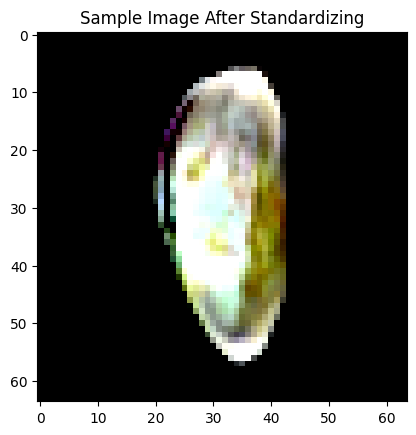

MLPClassifier Best Parameters: {'learning_rate_init': 0.001, 'hidden_layer_sizes': (100,), 'alpha': 0.0001}
MLPClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       249
           1       0.84      0.88      0.86       181

    accuracy                           0.88       430
   macro avg       0.87      0.88      0.87       430
weighted avg       0.88      0.88      0.88       430

Accuracy: 0.8767, F1 Score: 0.8744, Precision: 0.8726, Recall: 0.8770


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


GaussianNB Best Parameters: {'var_smoothing': 1e-07}
GaussianNB Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.97      0.74       249
           1       0.71      0.11      0.19       181

    accuracy                           0.61       430
   macro avg       0.66      0.54      0.47       430
weighted avg       0.65      0.61      0.51       430

Accuracy: 0.6070, F1 Score: 0.4659, Precision: 0.6569, Recall: 0.5392
           Model  Accuracy  F1 Score  Precision    Recall  \
0  MLPClassifier  0.876744  0.874379   0.872588  0.876978   
1     GaussianNB  0.606977  0.465893   0.656894  0.539184   

                                         Best Params  
0  {'learning_rate_init': 0.001, 'hidden_layer_si...  
1                           {'var_smoothing': 1e-07}  


In [34]:

def classify_and_tune_pistachio_images(dataset_path):
    # Load, preprocess dataset, and split
    image_size = (64, 64)  # Adjust depending on dataset
    X, y = load_dataset(dataset_path, image_size)

    # Encode labels to integers
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    print(f"Sample label before encoding: {y[0]}")
    print(f"Sample label after encoding: {y_encoded[0]}")

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Visualize a sample image after standardizing
    plt.imshow(X_train_scaled[0].reshape(image_size[0], image_size[1], -1), cmap='gray')
    plt.title('Sample Image After Standardizing')
    plt.show()

    # Define models and parameters for tuning
    models_params = {
        'MLPClassifier': {
            'model': MLPClassifier(max_iter=1000),
            'params': {
                'hidden_layer_sizes': [(100,), (50, 50), (100, 50)],
                'alpha': [0.0001, 0.001, 0.05],
                'learning_rate_init': [0.001, 0.01],
            }
        },
        'GaussianNB': {
            'model': GaussianNB(),
            'params': {
                'var_smoothing': np.logspace(-10, -7, 4)
            }
        }
    }

    results = []

    for model_name, mp in models_params.items():
        random_search = RandomizedSearchCV(mp['model'], mp['params'], n_iter=10, cv=3, scoring='f1_macro', random_state=42, n_jobs=-1)
        random_search.fit(X_train_scaled, y_train)
        best_model = random_search.best_estimator_
        y_pred = best_model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')

        print(f"{model_name} Best Parameters: {random_search.best_params_}")
        print(f"{model_name} Classification Report:")
        print(classification_report(y_test, y_pred))
        print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

        results.append({'Model': model_name, 'Accuracy': accuracy, 'F1 Score': f1, 'Precision': precision, 'Recall': recall, 'Best Params': random_search.best_params_})

        print("="*50)

    # Print the results in a DataFrame for a nice table format
    results_df = pd.DataFrame(results)
    print(results_df)


# Assuming the dataset_path is defined and points to your dataset directory
classify_and_tune_pistachio_images(dataset_path)
